# Time Series

https://towardsdatascience.com/mastering-time-series-analysis-in-python-8219047a0351

In [12]:
from dateutil.parser import parse
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


df=pd.read_csv('AirPassengers.csv')
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [13]:
df.tail()

,Month,#Passengers
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390
143,1960-12,432


In [14]:
df.shape

(144, 2)

### convert month into datetime object(easy to pull year/month)

In [15]:
df['Month']=pd.to_datetime(df['Month'],format='%Y-%m')
df.head()

,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


### convert month column into index (for future use of package)

In [16]:
df.index=df['Month']
del df['Month']
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


### generate a line using Seaborn

In [17]:
sns.lineplot(data=df)

<AxesSubplot:title={'center':'Passenger Time Series, Rolling Mean, Standard Deviation'}, xlabel='Month'>

### stationary analysis: make sure data change is constant

- stationary time series: no trend or seasonal patterns
- why check? bc it's assumption forARMA, ARIMA, Seasonal ARIMA
- stationary tests the degree present values change with past values

#### test-calculate a seven month rolling mean

In [18]:
rolling_mean=df.rolling(7).mean()
rolling_std=df.rolling(7).std()

#### overlay time series with 7 month rolling mean and standard deviation

In [19]:
# First, make Matplotlib plot for time series
plt.plot(df,color='blue',label='Original Passenger Data')

#then rolling mean
plt.plot(rolling_mean,color='red',label='Rolling Mean Passenger Number')

#rolling std
plt.plot(rolling_std,color='black',label='Rolling Standard Deviation in Passenger Number')

#add title
plt.title("Passenger Time Series, Rolling Mean, Standard Deviation")

#add legend
plt.legend(loc="best")

In [20]:
#import augmented Dickey-Fuller test from statsmodels package
from statsmodels.tsa.stattools import adfuller

In [21]:
adft=adfuller(df,autolag='AIC')

#store results ina data frame
output_df=pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3],adft[4]['1%'],adft[4]['5%'],adft[4]['10%']],"Metric": ["Test Statistics","p-value","no. of lags used","number of observations used","critical value (1%)","critical value (5%)","critical value (10%)"]})
output_df

,Values,Metric
0,0.815369,Test Statistics
1,0.991880,p-value
2,13.000000,no. of lags used
3,130.000000,number of observations used
4,-3.481682,critical value (1%)
5,-2.884042,critical value (5%)
6,-2.578770,critical value (10%)


- We can see our data is not stationary, since p-value is greater than 5% and test statistics is greater than the critical value.
- We can also draw the conclusions from inspecting the data, it has a clear increasing trend in the number of passengers -> not stationary


### Autocorrelation

- a measure of how correlated time series data is at a given point in time with past values

- implications: if passenger data has strong autocorrelation, there's a strong likelihood that they will be high tomorrow

use pandas to calculate a one month lag

In [22]:
ar_lag1=df['#Passengers'].autocorr(lag=1)
ar_lag1

0.9601946480498523

try 3,6,9 months

In [23]:
ar_lag3=df['#Passengers'].autocorr(lag=3)
print("3 month lag:", ar_lag3)

ar_lag6=df['#Passengers'].autocorr(lag=6)
print("6 month lag:", ar_lag6)

ar_lag9=df['#Passengers'].autocorr(lag=9)
print("9 month lag:", ar_lag9)

3 month lag: 0.837394765081794
6 month lag: 0.7839187959206183
9 month lag: 0.8278519011167601


note, even with a 9 month lag, the data is still highly autocorrelated, illustrating the short and long term trends in the data

### Decomposition

Trend decomposition is another useful way to visualize the trends in time series data. 

Import seasonal_decompose from statsmodels package

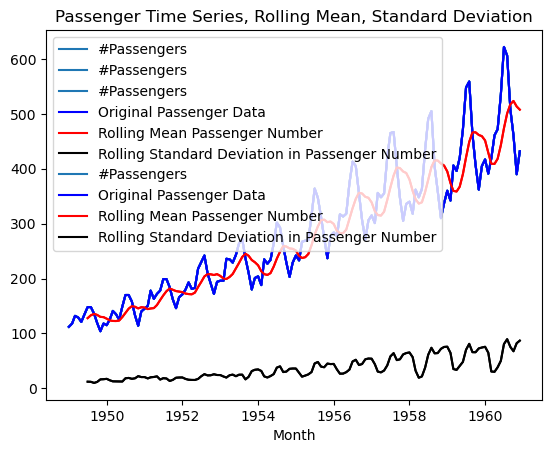

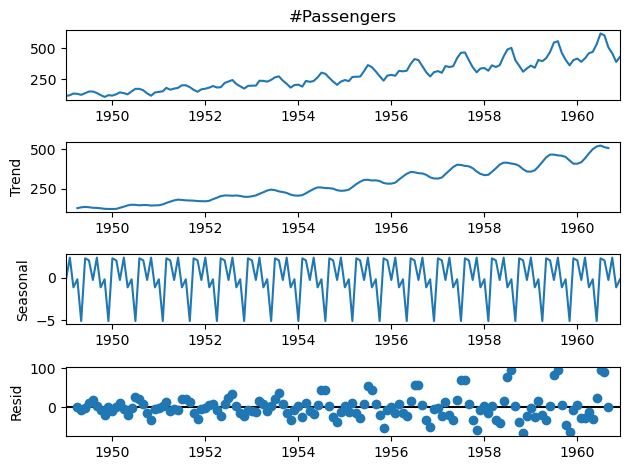

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose

#pass data frame into method, plot result

decompose=seasonal_decompose(df['#Passengers'],model='additive',period=7)

decompose.plot()

plt.show()

We can clearly see the increasing trend in number of passengers and seasonality patterns in the rise and falll in values each year.

### Forecasting

Time series forecasting allows us to predict future values in a time series given current and past data.

Here, we use ARIMA method to forecast the number of passengers.

ARIMA allows us to forecast future values in terms of a linear combination of past values.

Use auto_arima package, forgo the time consuming hyperparameter tuning.

In [25]:
#split our data for training and testing, visualize the split

df['Date']=df.index
train=df[df['Date']<pd.to_datetime("1960-08",format='%Y-%m')]
train['train']=train['#Passengers']

del train['Date']
del train['#Passengers']

train

<ipython-input-25-da69bee101e0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['train']=train['#Passengers']


,train
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-03-01,419
1960-04-01,461
1960-05-01,472


In [26]:
test=df[df['Date']>=pd.to_datetime("1960-08",format='%Y-%m')]
del test['Date']
test['test']=test['#Passengers']
del test['#Passengers']

test

<ipython-input-26-620b086a9808>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['test']=test['#Passengers']


,test
Month,
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390
1960-12-01,432


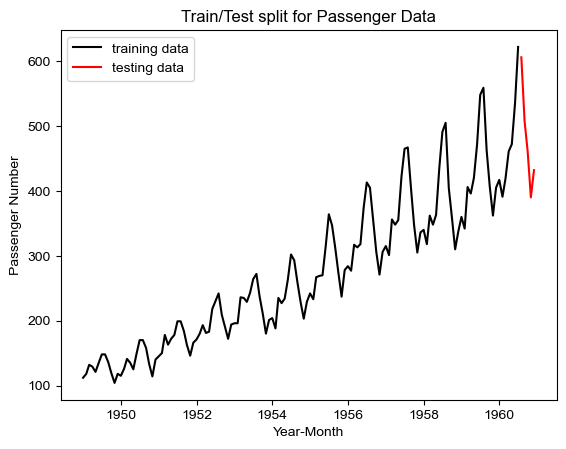

In [27]:
plt.plot(train,color="black",label="training data")
plt.plot(test,color="red",label="testing data")

plt.title("Train/Test split for Passenger Data")
plt.ylabel("Passenger Number")
plt.xlabel("Year-Month")
plt.legend(loc='best')

sns.set()
plt.show()

Import auto_arima from pmdarima package, train our model, generate predictions

In [31]:
from pmdarima.arima import auto_arima

model=auto_arima(train,trace=True, error_action='ignore',suppress_warnings=True)

model.fit(train)

forecast=model.predict(n_periods=len(test))

forecast=pd.DataFrame(forecast,index=test.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1352.593, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1340.702, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1336.259, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1352.415, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1329.986, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1335.098, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1336.923, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1329.407, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1335.407, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1339.796, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1325.560, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1336.3

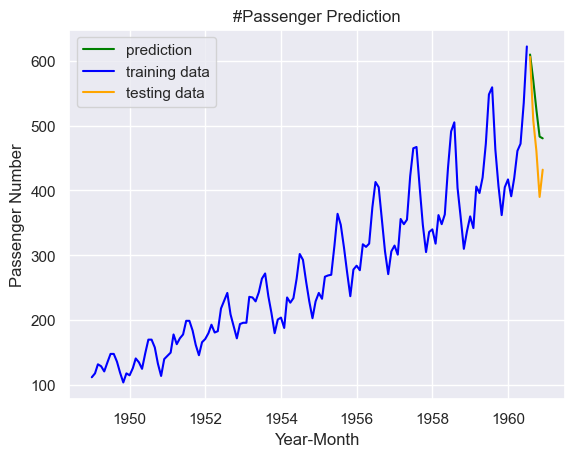

In [32]:

plt.plot(forecast,color="green",label="prediction")
plt.plot(train,color="blue",label="training data")
plt.plot(test,color="orange",label="testing data")

plt.title("#Passenger Prediction")
plt.ylabel("Passenger Number")
plt.xlabel("Year-Month")
plt.legend(loc='best')

sns.set()
plt.show()

Finally, calculate root mean square error(RMSE)

In [34]:
from math import sqrt
from sklearn.metrics import mean_squared_error
rms=sqrt(mean_squared_error(test,forecast))
print("RMSE:",rms)

RMSE: 61.36535942376535
